# Import Libraries

In [1]:
!pip install -q fairlearn pandas==2.0.3
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.simplefilter(action='ignore', category='PerformanceWarning')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.5 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
mizani 0.11.0 requires pandas>=2.1.0, but you have pandas 2.0.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
plotnine 0.13.2 requires pandas<3.0.0,>=2.1.0, but you have pandas 2.0.3 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is in

# Prepare Dataset

In [2]:
train_df = pd.read_csv('/kaggle/input/ca-independent-medical-review/Independent_Medical_Review__IMR__Determinations__Trend.csv')
train_df = train_df[['Findings','Patient Gender','Age Range','Type']].dropna().reset_index(drop=True)
train_df['Type'] = train_df['Type'].map({'Urgent Care': 1,'Medical Necessity': 1,'Experimental/Investigational': 0})
train_df = train_df.sample(frac=1,random_state=42).reset_index(drop=True)
train_df

,Findings,Patient Gender,Age Range,Type
0,A male enrollee requested Harvoni 90/400 mg fo...,Male,51-64,1
1,A 31-year-old male enrollee has requested adul...,Male,31-40,1
2,A 60-year-old male enrollee has requested Soun...,Male,51-64,0
3,A 38-year-old male enrollee has requested arti...,Male,31-40,0
4,The patient is a 53-year-old female with right...,Female,51-64,1
...,...,...,...,...
18010,A 59-year-old female enrollee has requested fo...,Female,51-64,1
18011,A 56-year-old female enrollee has requested co...,Female,51-64,1
18012,A 57-year-old female enrollee has requested ma...,Female,51-64,1
18013,Nature of Statutory Criteria/Case Summary: An...,Male,31-40,1


In [3]:
from sklearn.preprocessing import LabelEncoder
feats = ['Patient Gender','Age Range']
le = LabelEncoder()
for f in feats:
    le.fit(train_df[f].values.reshape(-1,))
    train_df[f] = le.transform(train_df[f].values.reshape(-1,))

In [4]:
CouVec = TfidfVectorizer(stop_words='english',max_features=50)
CouVec.fit(train_df['Findings'].values)
train_words = pd.DataFrame(CouVec.transform(train_df['Findings']).toarray())
train_words.shape

(18015, 50)

In [5]:
train_words = pd.concat([train_df[['Patient Gender','Age Range','Type']],train_words],axis=1).copy()
train_df = train_words
train_df.columns = train_df.columns.astype(str)

In [6]:
# DataFrame to store the metrics values
metrics_values = pd.DataFrame(columns=['Original','Corr','Expon','Grid','Thres'],index=range(2))

# Original Model

In [7]:
from sklearn.utils.extmath import softmax
from sklearn.linear_model import RidgeClassifier

class RidgeClassifierwithProba(RidgeClassifier):
    def predict_proba(self, X):
        d = self.decision_function(X)
        d_2d = np.c_[-d, d]
        return softmax(d_2d)
    
model = RidgeClassifierwithProba()

In [8]:
# CV and OOF Predictions

X = train_df.drop('Type',axis=1)
y = train_df['Type']

y_pred = pd.Series(0,index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_Train.values,y_Train.values)

    preds = model.predict(X_Test.values)
    y_pred[test_index] = preds
    
    scores.append(f1_score(y_Test.values,preds))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')

0.9798172124904798
0.9830894926847806
0.9834064466908259
0.9788692175899487
0.9817212490479817
Mean: 0.9813807237008033 
STD:  0.0017827861809340511 



# Metrics

In [9]:
def multiclass_selection_rate(y_true, y_pred, desired_class):
    """Calculate the selection rate for a specific class in a multiclass classification problem.
    The selection rate is defined as the fraction of predicted labels that are equal to the desired class.
    Args:
        y_true : array-like
            The true labels.
        y_pred : array-like
            The predicted labels.
        desired_class : any
            The class for which to calculate the selection rate.
    Returns:
        float
            The selection rate for the desired class.
    """
    selected = (y_pred == desired_class).sum()
    total = y_pred.shape[0]
    return selected / total

In [10]:
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_ratio
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import pandas as pd

metrics = {
    'accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
    'selection_rate': lambda y_true, y_pred: multiclass_selection_rate(y_true, y_pred,1),
    'count': lambda y_true, y_pred: len(y_true),
}

### Table for Gender

#### Gender: {0: Female , 1: Male}
#### Ethnicity: {0: Asian , 1: Black , 2: Indian , 3: Others , 4: White}

In [11]:
# Create a MetricFrame object
mf = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=X[['Patient Gender']])

# Compute the metrics for each group defined by the sensitive features
results = {}
for metric_name in metrics.keys():
        results[metric_name] = mf.by_group[metric_name]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df


,accuracy,selection_rate,count
Patient Gender,,,
0,0.973332,0.714932,10387.0
1,0.972208,0.747902,7628.0


### Table for Ethnicity

In [12]:
# Create a MetricFrame object
mf = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=X[['Age Range']])

# Compute the metrics for each group defined by the sensitive features
results = {}
for metric_name in metrics.keys():
        results[metric_name] = mf.by_group[metric_name]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

,accuracy,selection_rate,count
Age Range,,,
0,0.987578,0.906268,1771.0
1,0.987248,0.883103,1882.0
2,0.984160,0.782369,1452.0
3,0.978324,0.746146,2076.0
4,0.969043,0.685317,3521.0
5,0.963675,0.652641,6607.0
6,0.963173,0.643059,706.0


### Table for Gender and Ethnicity

In [13]:
# Create a MetricFrame object
mf = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=X[['Patient Gender','Age Range']])

# Compute the metrics for each group defined by the sensitive features
results = {}
for metric_name in metrics.keys():
        results[metric_name] = mf.by_group[metric_name]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

accuracy  selection_rate   count
Patient Gender Age Range                                  
0              0          0.978836        0.890653   567.0
               1          0.990132        0.883772   912.0
               2          0.991071        0.780134   896.0
               3          0.980309        0.743319  1422.0
               4          0.968261        0.685652  2300.0
               5          0.965700        0.649180  3965.0
               6          0.966154        0.640000   325.0
1              0          0.991694        0.913621  1204.0
               1          0.984536        0.882474   970.0
               2          0.973022        0.785971   556.0
               3          0.974006        0.752294   654.0
               4          0.970516        0.684685  1221.0
               5          0.960636        0.657835  2642.0
               6          0.960630        0.645669   381.0

### Demographic Parity & Equalized Odds

In [14]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
metrics_values.loc[0,'Original'] = demographic_parity_difference(y,y_pred,sensitive_features=X[['Patient Gender','Age Range']])
metrics_values.loc[1,'Original'] = equalized_odds_difference(y,y_pred,sensitive_features=X[['Patient Gender','Age Range']])

# Mitigation Algorithms

# Preprocessing Algorithms:

In [15]:
from fairlearn.preprocessing import CorrelationRemover

X = train_df.drop('Type',axis=1)
y = train_df['Type']

y_pred_1 = pd.Series(0,index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X.values, y.values):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    corr_remover = CorrelationRemover(sensitive_feature_ids=['Patient Gender','Age Range'])
    corr_remover.fit(X_Train)
    X_Train = corr_remover.transform(X_Train)
    X_Test = corr_remover.transform(X_Test)

    model.fit(X_Train,y_Train)

    preds = model.predict(X_Test)
    y_pred_1[test_index] = preds
    
    scores.append(f1_score(y_Test.values,preds))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')

0.976673620329983
0.9772813328284741
0.9770616113744076
0.9742228961334344
0.9775835866261399
Mean: 0.9765646094584877 
STD:  0.0012078511852497017 



In [16]:
y_pred_1.to_csv('y_pred_Corr.csv',index=False)

#### Demographic Parity and Equalized Odds:

In [17]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
metrics_values.loc[0,'Corr'] = demographic_parity_difference(y,y_pred_1,sensitive_features=X[['Patient Gender','Age Range']])
metrics_values.loc[1,'Corr'] = equalized_odds_difference(y,y_pred_1,sensitive_features=X[['Patient Gender','Age Range']])

# In-processing Algorithms:

#### Exponentiated Gradient

In [18]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds

X = train_df.drop('Type',axis=1)
y = train_df['Type']

y_pred_2 = pd.Series(0,index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X.values, y.values):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    expgrad = ExponentiatedGradient(model, constraints=EqualizedOdds(), max_iter=50)
    expgrad.fit(X_Train,y_Train,sensitive_features=X_Train[['Patient Gender','Age Range']])

    preds = expgrad.predict(X_Test)
    y_pred_2[test_index] = preds
    
    scores.append(f1_score(y_Test.values,preds))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')

0.9599849708810821
0.9492481203007519
0.956952380952381
0.952865761689291
0.9552405818724357
Mean: 0.9548583631391884 
STD:  0.003640285536757221 



In [19]:
y_pred_2.to_csv('y_pred_expGrad.csv',index=False)

In [20]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
metrics_values.loc[0,'Expon'] = demographic_parity_difference(y,y_pred_2,sensitive_features=X[['Patient Gender','Age Range']])
metrics_values.loc[1,'Expon'] = equalized_odds_difference(y,y_pred_2,sensitive_features=X[['Patient Gender','Age Range']])

#### Grid Search

In [21]:
from fairlearn.reductions import DemographicParity, GridSearch, EqualizedOdds

X = train_df.drop('Type',axis=1)
y = train_df['Type']

y_pred_3 = pd.Series(0,index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X.values, y.values):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
    
    grid = GridSearch(model, constraints=DemographicParity(),grid_size=100)
    grid.fit(X_Train,y_Train,sensitive_features=X_Train[['Patient Gender','Age Range']])

    preds = grid.predict(X_Test)
    y_pred_3[test_index] = preds
    
    scores.append(f1_score(y_Test.values,preds))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')

0.9116877891772279
0.9040985261457702
0.9104
0.8983050847457628
0.9125125125125126
Mean: 0.9074007825162548 
STD:  0.005424760460134855 



### NOTE: It gave good results with high grid_size values

In [22]:
y_pred_3.to_csv('y_pred_gridsearch.csv',index=False)

In [23]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
metrics_values.loc[0,'Grid'] = demographic_parity_difference(y,y_pred_3,sensitive_features=X[['Patient Gender','Age Range']])
metrics_values.loc[1,'Grid'] = equalized_odds_difference(y,y_pred_3,sensitive_features=X[['Patient Gender','Age Range']])

# Postprocessing Algorithms:

In [24]:
from fairlearn.reductions import DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

X = train_df.drop('Type',axis=1)
y = train_df['Type']

y_pred_4 = pd.Series(0,index=X.index)

scores = []                   
for train_index, test_index in StratifiedKFold(n_splits=5).split(X.values, y.values):
    X_Train, X_Test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_Train,y_Train)
    
    threshopt = ThresholdOptimizer(estimator=model, constraints='equalized_odds',
                                       prefit=True, predict_method='auto')
    
    threshopt.fit(X_Train,y_Train,sensitive_features=X_Train[['Patient Gender','Age Range']])
    preds = threshopt.predict(X_Test,sensitive_features=X_Test[['Patient Gender','Age Range']])
    y_pred_4[test_index] = preds
    
    scores.append(f1_score(y_Test.values,preds))
    print(scores[-1])

print("Mean:",np.mean(scores),"\nSTD: ", np.std(scores),'\n')

0.9714729283912286
0.9724271844660195
0.9721685349826054
0.969215876089061
0.974111282843895
Mean: 0.9718791613545619 
STD:  0.0015889963119135413 



In [25]:
y_pred_4.to_csv('y_pred_Threshold.csv',index=False)

In [26]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
metrics_values.loc[0,'Thres'] = demographic_parity_difference(y,y_pred_4,sensitive_features=X[['Patient Gender','Age Range']])
metrics_values.loc[1,'Thres'] = equalized_odds_difference(y,y_pred_4,sensitive_features=X[['Patient Gender','Age Range']])

In [27]:
metrics_values.to_csv('Metrics_Values.csv',index=False)

# Plot for Comparison:

## Demographic Parities

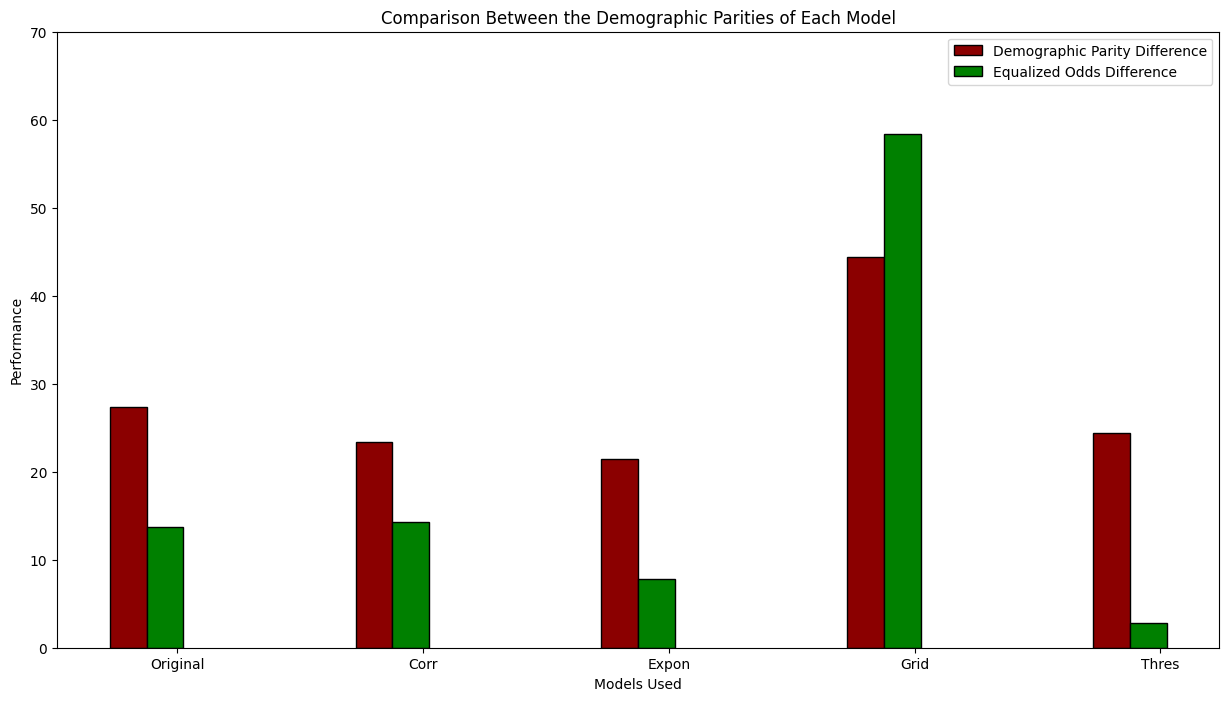

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# creating the dataset
metric_1 = {'Original':metrics_values.loc[0,'Original']*100,
            'Corr':metrics_values.loc[0,'Corr']*100,
            'Expon':metrics_values.loc[0,'Expon']*100, 
            'Grid':metrics_values.loc[0,'Grid']*100,
            'Thres':metrics_values.loc[0,'Thres']*100}
metric_2 = {'Original':metrics_values.loc[1,'Original']*100,
            'Corr':metrics_values.loc[1,'Corr']*100,
            'Expon':metrics_values.loc[1,'Expon']*100, 
            'Grid':metrics_values.loc[1,'Grid']*100,
            'Thres':metrics_values.loc[1,'Thres']*100}

#Values of Metrics   
metric_1 = list(metric_1.values())
metric_2 = list(metric_2.values())

#Define the plot
fig = plt.subplots(figsize =(15, 8))

#Define the Distances
br1 = np.arange(5)
br2 = [x + 0.15 for x in br1]

#Create the bar plot
plt.bar(br1, metric_1, color ='darkred', width = 0.15,
        edgecolor ='black', label ='Demographic Parity Difference')
plt.bar(br2, metric_2, color ='g', width = 0.15,
        edgecolor ='black', label ='Equalized Odds Difference')

#Name the of The x-axis
plt.xticks([r + 0.20 for r in range(5)],
        ['Original', 'Corr', 'Expon', 'Grid','Thres'])

#y-axis Boundaries
plt.ylim((0,70))

plt.xlabel("Models Used")
plt.ylabel("Performance")
plt.title("Comparison Between the Demographic Parities of Each Model")
plt.legend()
plt.show()
